<a href="https://colab.research.google.com/github/zhensongren/learn-ml/blob/master/Bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Optimization

## Objective function and data

Optima: x=0.900, y=0.810


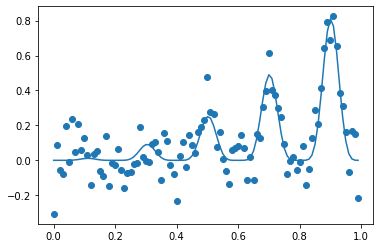

In [9]:
# example of the test problem
from math import sin
from math import pi
from numpy import arange
from numpy.random import normal
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
simplefilter("ignore")

from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# grid-based sample of the domain [0,1]
X = arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
# plot the points with noise
pyplot.scatter(X, ynoise)
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

Surrogate model and Bayesian optimization 

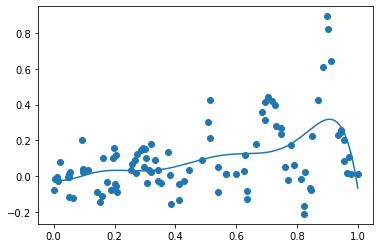

>x=0.905, f()=0.317793, actual=0.703
>x=0.904, f()=0.348641, actual=0.776
>x=0.908, f()=0.380598, actual=0.777
>x=0.347, f()=0.036140, actual=-0.072
>x=0.470, f()=0.091927, actual=-0.016
>x=0.385, f()=0.041548, actual=-0.004
>x=0.109, f()=0.013493, actual=-0.140
>x=0.277, f()=0.021202, actual=0.005
>x=0.428, f()=0.060935, actual=0.035
>x=0.906, f()=0.406665, actual=0.887
>x=0.939, f()=0.391467, actual=0.382
>x=0.007, f()=-0.016272, actual=0.203
>x=0.616, f()=0.108857, actual=-0.032
>x=0.894, f()=0.431219, actual=0.820
>x=0.498, f()=0.091219, actual=0.143
>x=0.267, f()=0.020611, actual=0.069
>x=0.493, f()=0.091843, actual=0.238
>x=0.853, f()=0.374846, actual=0.192
>x=0.238, f()=0.022492, actual=0.039
>x=0.981, f()=0.090069, actual=-0.004
>x=0.826, f()=0.298333, actual=0.002
>x=0.045, f()=-0.018854, actual=0.047
>x=0.972, f()=0.180288, actual=0.027
>x=0.965, f()=0.238575, actual=0.091
>x=0.466, f()=0.092386, actual=0.210
>x=0.127, f()=0.011099, actual=-0.030
>x=0.201, f()=0.021303, actua

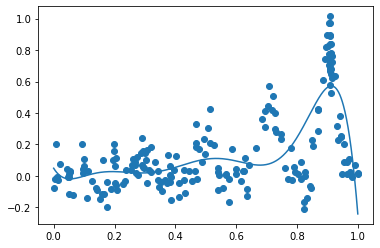

Best Result: x=0.909, y=1.015


In [10]:
# fitting a Gaussian Process regression model on noisy samples
# example of bayesian optimization for a 1d function from scratch

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

In [11]:
! pip install scikit-optimize

# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Best Accuracy: 0.884
Best Parameters: n_neighbors=5, p=2
